# RGI01 outlines selection

F. Maussion & S. Galos, June 2021

Strictly equivalent to RGI6.

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from utils import mkdir
import os

In [2]:
# Region of interest
reg = 1

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '01_rgi60_Alaska.zip')

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + os.path.join(l2_dir, f'RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp'))

## Outline selection 

In [4]:
# List analysts
shp.analysts.unique()

array(['Beedle, Matthew', 'Manley, William', 'Herreid, Samuel',
       'Frey, Holger; Le Bris, Raymond; Paul, Frank', 'Rich, Justin',
       'Bolch, Tobias',
       'Beedle, Matthew; Berthier, Etienne; Bolch, Tobias; Burgess, Evan; Cogley, Graham; Forster, Richard; Giffen, Bruce A.; Hall, Dorothy K.; Kienholz, Christian; LeBris, Raymond; Manley, William',
       'Maraldo, Dean'], dtype=object)

For this region selecting glaciers can be done either by analyst or by "proc_desc":

In [5]:
sel_analysts = ('Beedle, Matthew; Berthier, Etienne; Bolch, Tobias; Burgess, Evan; Cogley, Graham; '
                'Forster, Richard; Giffen, Bruce A.; Hall, Dorothy K.; Kienholz, Christian; LeBris, Raymond; Manley, William')
len(shp.loc[shp.analysts == sel_analysts])

27106

In [6]:
sel_proc_desc = ('Semi-automated glacier classification.; From Randolph Glacier Inventory Version 5.0. Source file: 01_rgi50_Alaska.zip.  '
                 'See http://www.glims.org/RGI/.  GLIMS IDs were adjusted and metadata was added at NSIDC.')
len(shp.loc[shp.proc_desc == sel_proc_desc])

27106

In [7]:
rgi7 = shp.loc[shp.analysts == sel_analysts].copy()

## Write out and tar 

In [8]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI01.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI01'], returncode=0)


## Consistency check with RGI6 

In [9]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if 'shp' in f.filename:
            fn = f.filename

In [10]:
rgi6 = gpd.read_file('zip://' + rgi6_reg_file + '/' + fn)

In [11]:
len(rgi7), len(rgi6)

(27106, 27108)

There are two missing glaciers! One has been wrongly attributed to Region 1 in RGI6 (`RGI60-01.05285`), another we don't know yet.

In [12]:
# Remove wrongly attributed glacier from RGI6
rgi6 = rgi6.loc[rgi6.RGIId != 'RGI60-01.05285'].copy()

Test the areas:

In [13]:
rgi6['Area_us'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [14]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['Area_us'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (m2)', rgi6['Area_us'].sum() - rgi7['area'].sum())

Area RGI7a (km2) 86724.5510826829
Area RGI6 (km2) 86724.631
Area RGI6 computed by us (km2) 86724.5515302422
diff areas RGI6 - RGI7 computed by us (m2) 447.5592956542969


So, the difference is really small... BUT this one glacier less is intriging.

### Find the missing glacier 

In [15]:
df_ref = rgi6
df_ref['area'] = rgi6['Area_us'] 

In [16]:
from utils import haversine
import progressbar

In [17]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [18]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [19]:
df_ref_orig = df_ref.copy()

In [20]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (27106 of 27106) |##################| Elapsed Time: 0:00:27 Time:  0:00:27


In [21]:
print(len(not_found), len(df_ref))

1 2


In [22]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

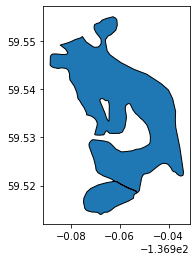

In [23]:
for i, k in enumerate(not_found.keys()):
    ax = rgi7.iloc[[k]].plot(edgecolor='k');

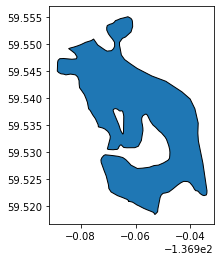

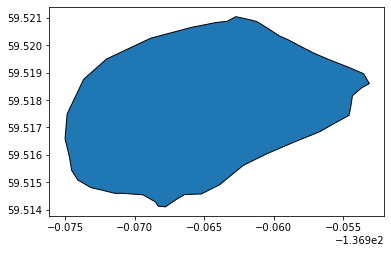

In [24]:
for i, k in enumerate(range(len(df_ref))):
    ax = df_ref.iloc[[i]].plot(edgecolor='k');

We have found the problem! Reported here: https://github.com/GLIMS-RGI/glims_issue_tracker/issues/5

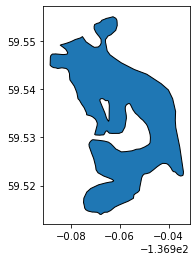

In [28]:
pb_rgi7.buffer(0).plot(edgecolor='k');

In [25]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [26]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI01.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI01'], returncode=0)
